# Trait Weight Based Optimization

In [1]:
#imports required
import numpy as np
import numpy.random as rnd
import scipy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from numpy import linalg as LA
import cvxpy as cp
import exp_setup
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from trait_weight_optimization.exp_setup import *

%load_ext autoreload
%autoreload 2

In [2]:
#installations

### Setup

We will modelling the robot team allocation to solve few independent challenges.

The species will be the 20 types of robots(divided into 4 groups).For each demonstration, each type of robot from the group will be randomly assigned to the expert.

There are 9 traits for each robot specie which are generic and mostly applicable to all of them. 

There are three task which are required to be completed with the allocation. 

In [3]:
# experiment settings
num_species = 4 #drone,rover,mini-rover,mini-drone
num_tasks = 3  #pick,search for target,move object
num_traits = 9 #speed,footprint,payload,reach,weight,sensing frequency,sensing range,color,battery capacity
traits = ["speed","footprint","payload","reach","weight","sensing frequency","sensing range","color","battery"]
num_demo = 1000

## Random Q vs Deterministic Q

### RANDOM Q

In [4]:
Q = []
for i in range(num_demo):
    Q.append(get_random_q())
Q = np.array(Q)
Q.shape

(1000, 4, 9)

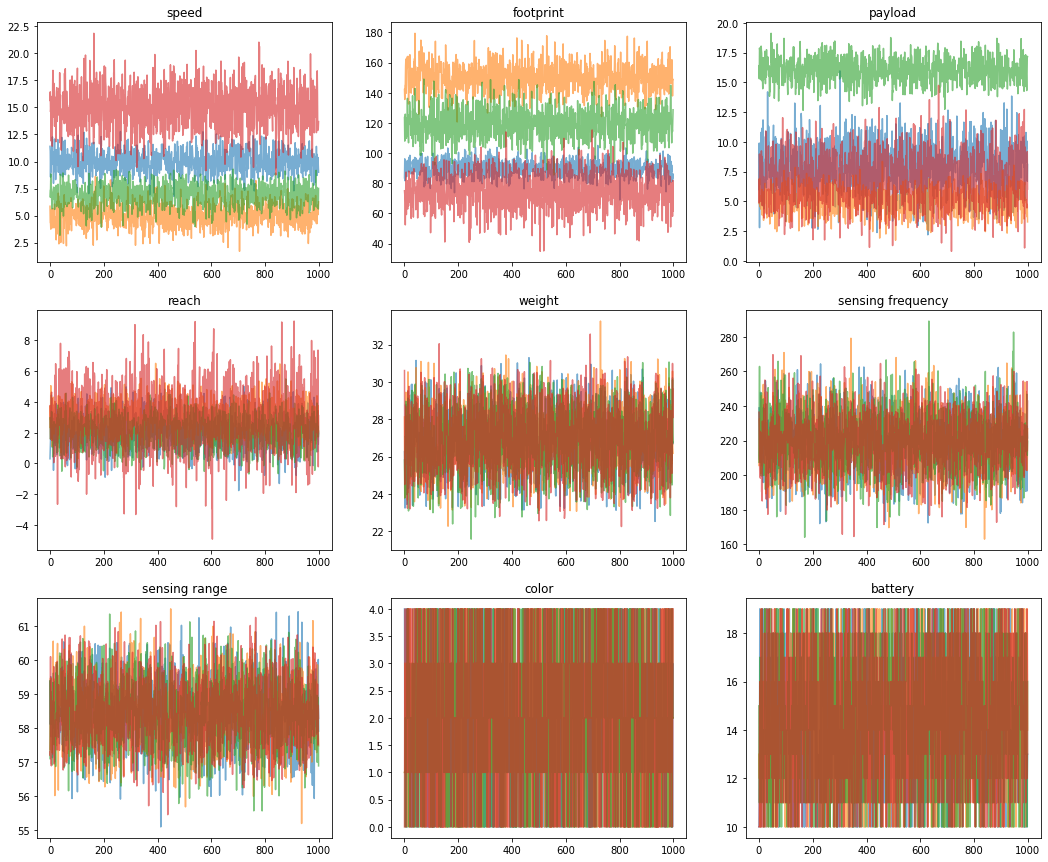

In [5]:
#Visualizations
plt.rcParams["figure.figsize"] = (18,15)

#Species across all the 9 traits
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.plot(range(num_demo), Q[:,:,i],alpha=0.6)
    ax.set_title(traits[i])

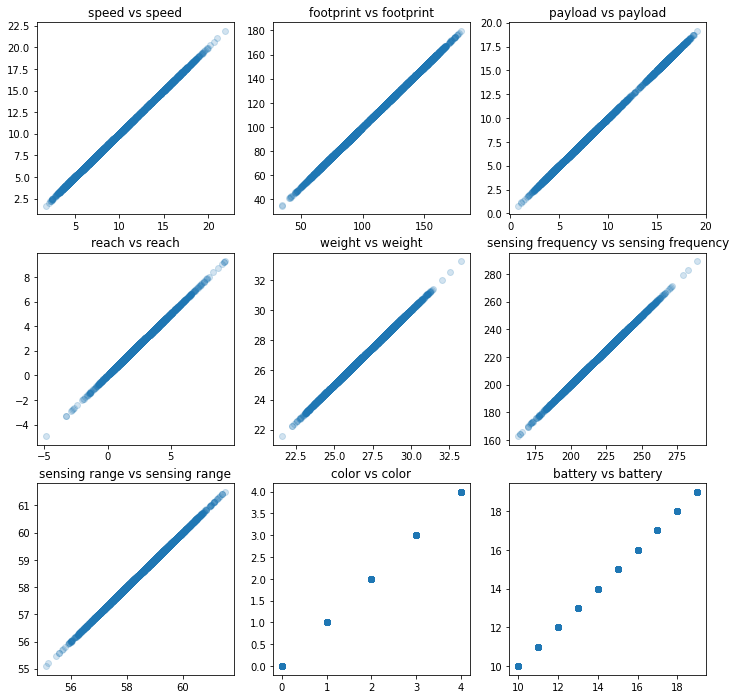

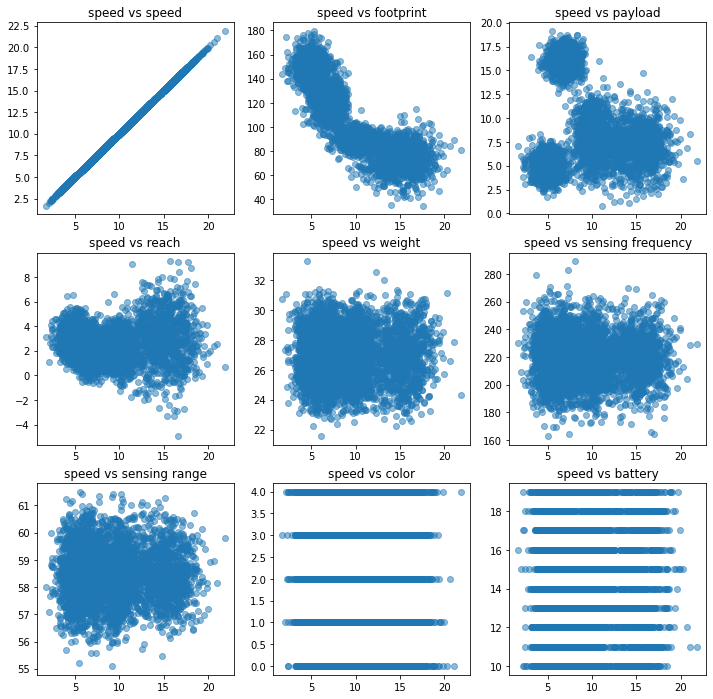

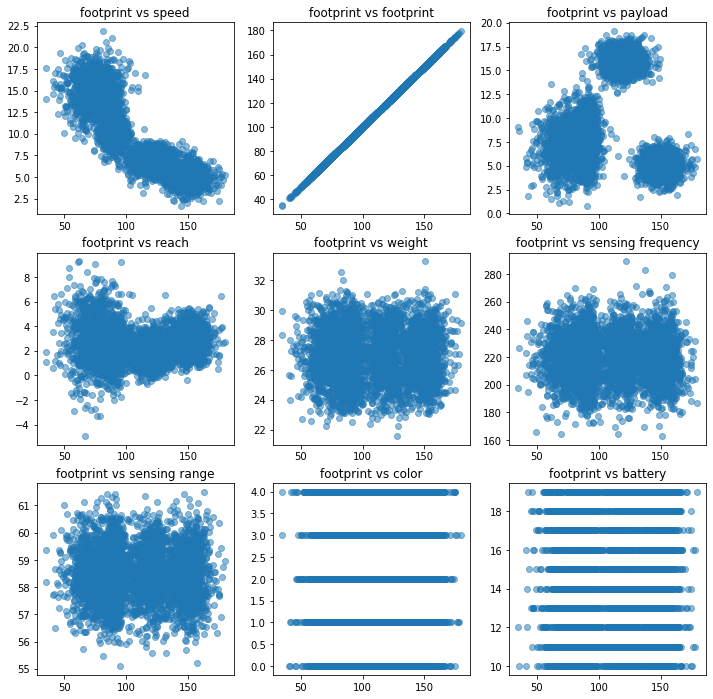

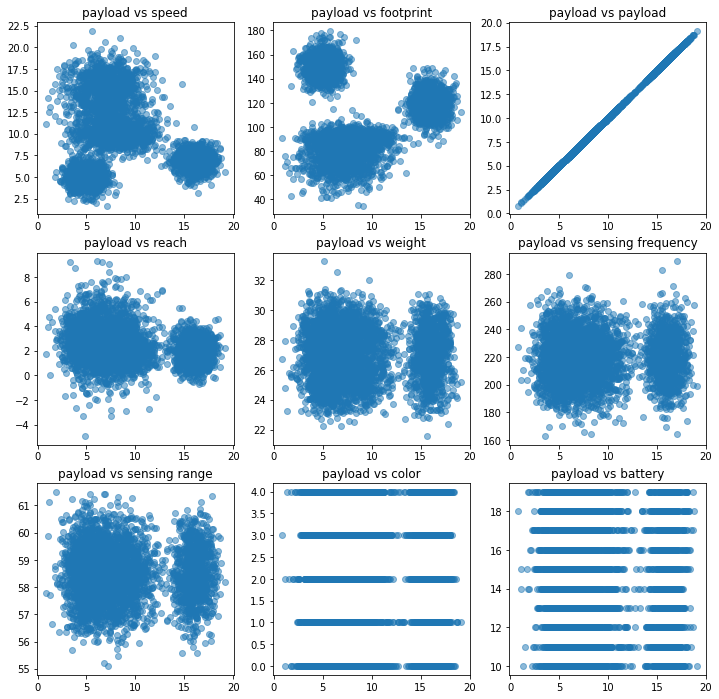

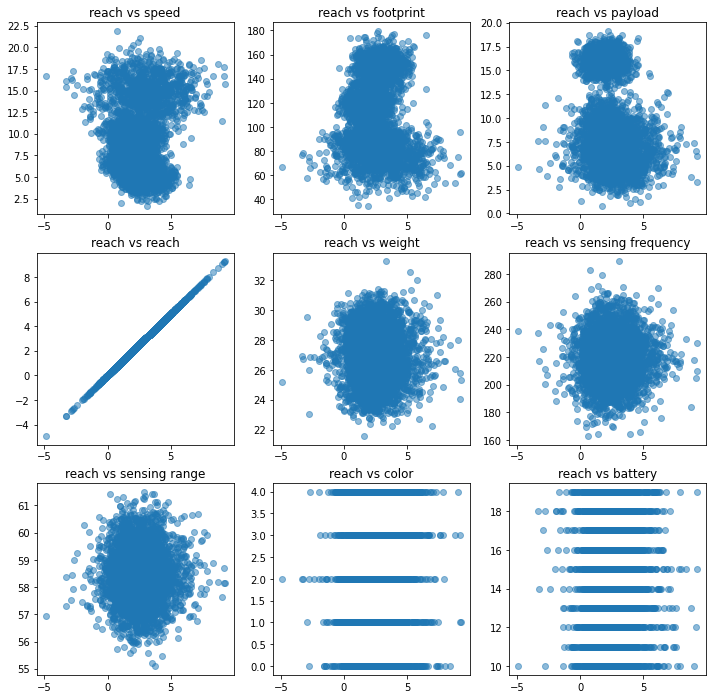

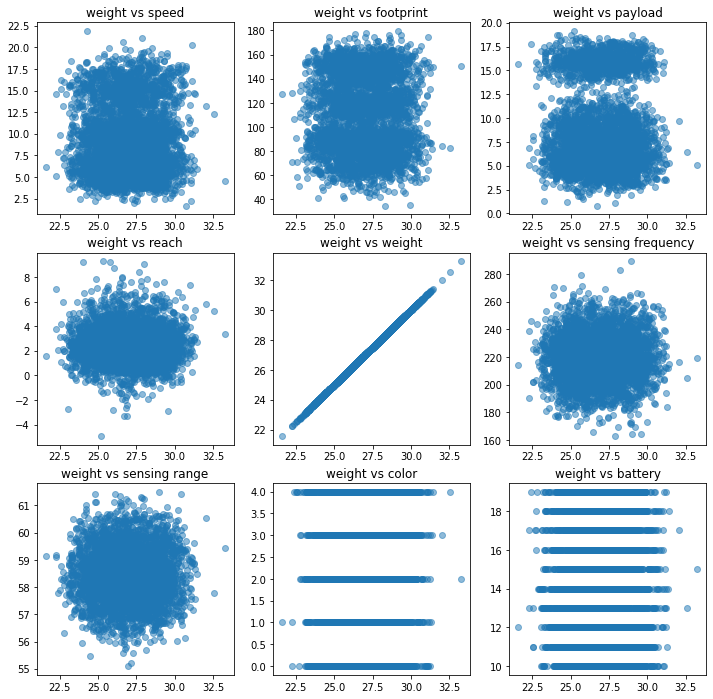

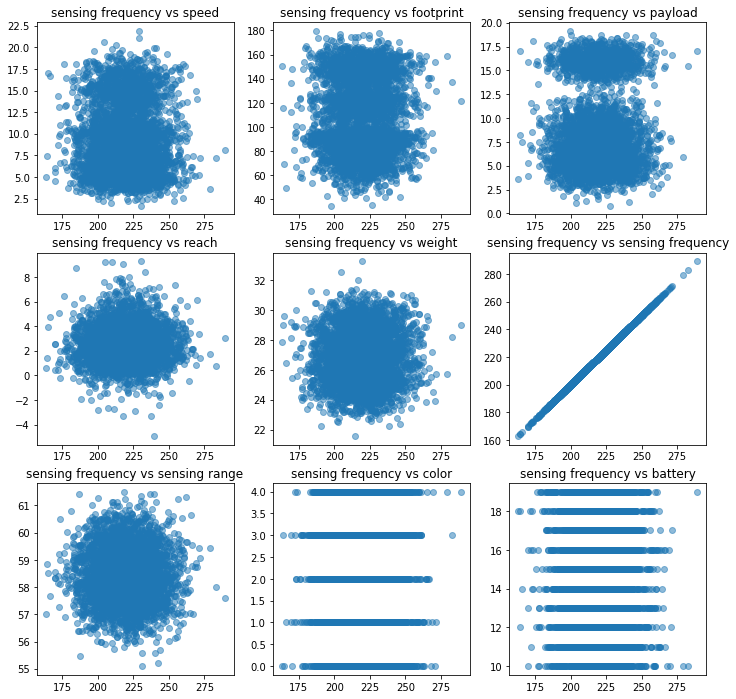

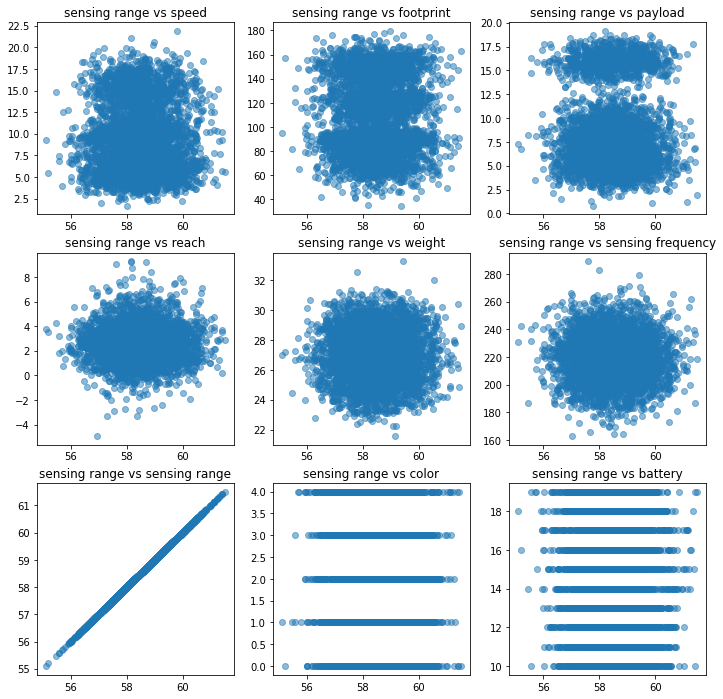

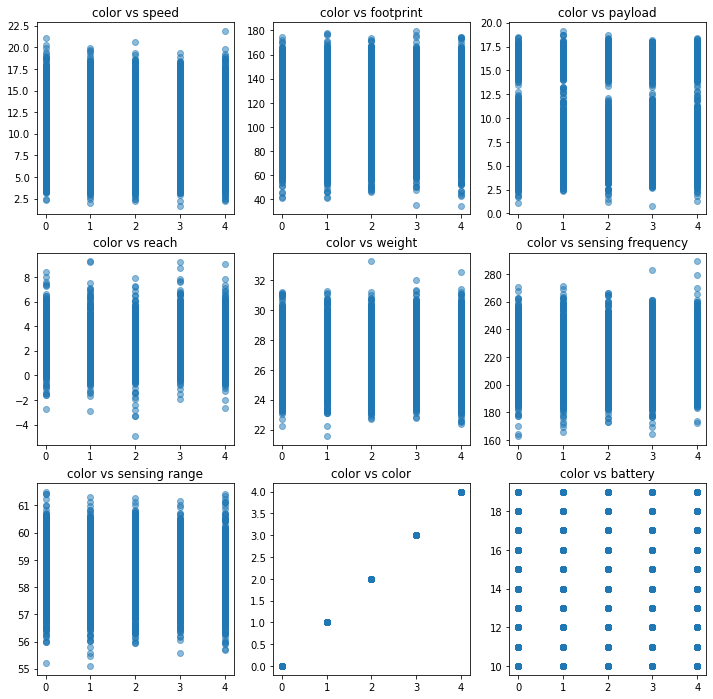

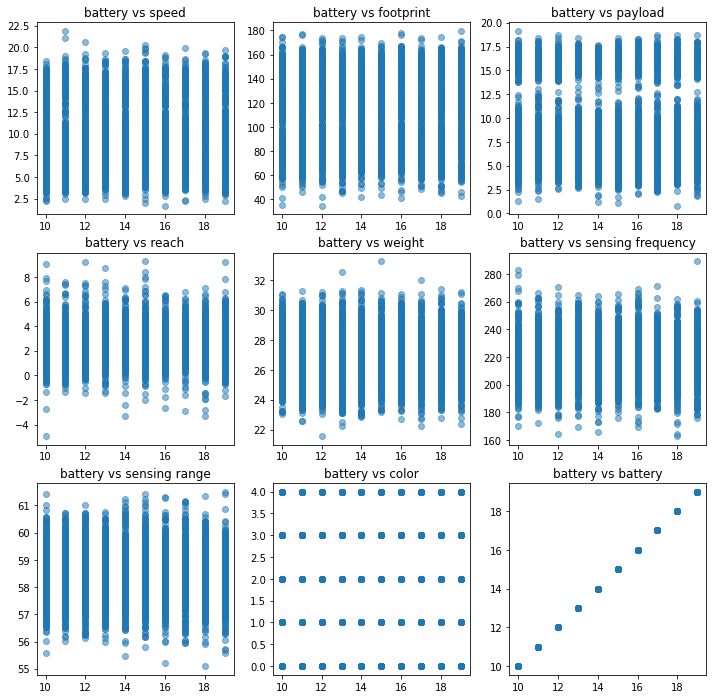

In [6]:
#Visualization Trait space

#Traits with respect to other traits can be mapped to visualize the traits spaces

#Visualizations
plt.rcParams["figure.figsize"] = (12,12)

#self maps
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.scatter(Q[:,:,i], Q[:,:,i],alpha=0.2)
    ax.set_title(traits[i] + " vs "+ traits[i] )

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(Q[:,:,t], Q[:,:,i],alpha=0.5)
        ax.set_title(traits[t] + " vs "+ traits[i] )

### DETERMINISTIC Q


In [7]:
Q_det = []
for i in range(num_demo):
    Q_det.append(get_deterministic_q())
Q_det = np.array(Q_det)
Q_det.shape

(1000, 4, 9)

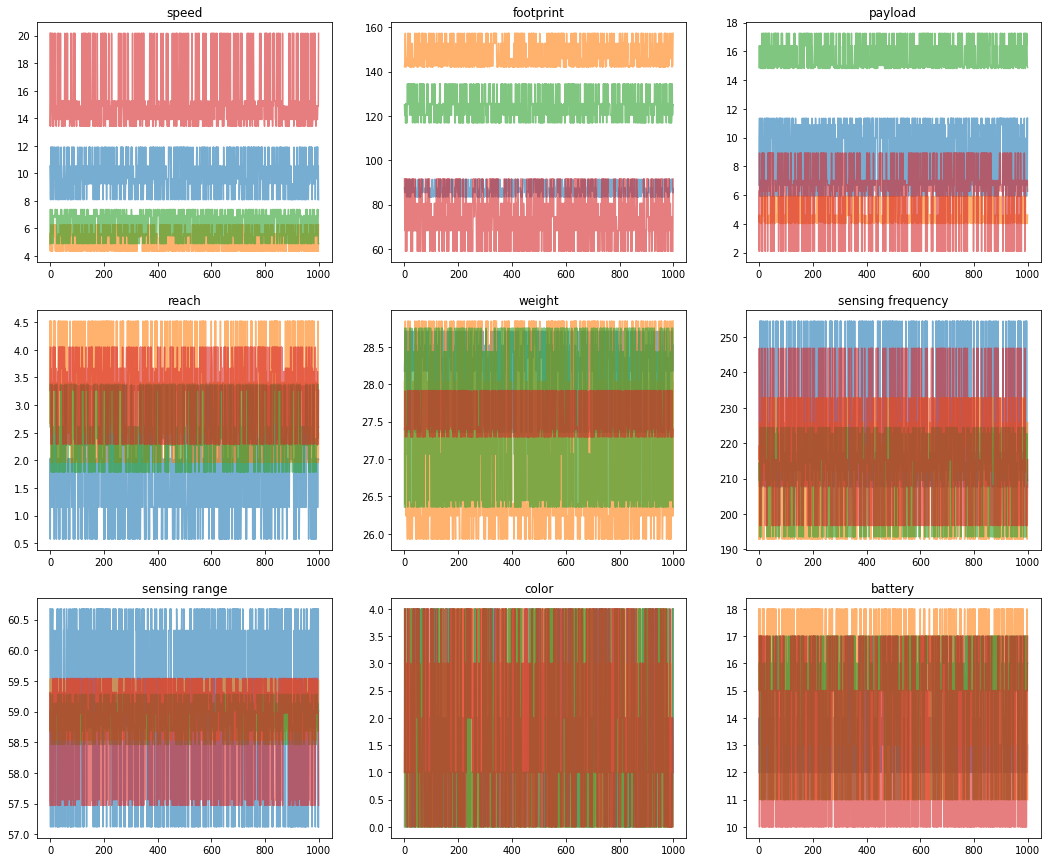

In [8]:
plt.rcParams["figure.figsize"] = (18,15)

#Species across all the 9 traits
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.plot(range(num_demo), Q_det[:,:,i],alpha=0.6)
    ax.set_title(traits[i])

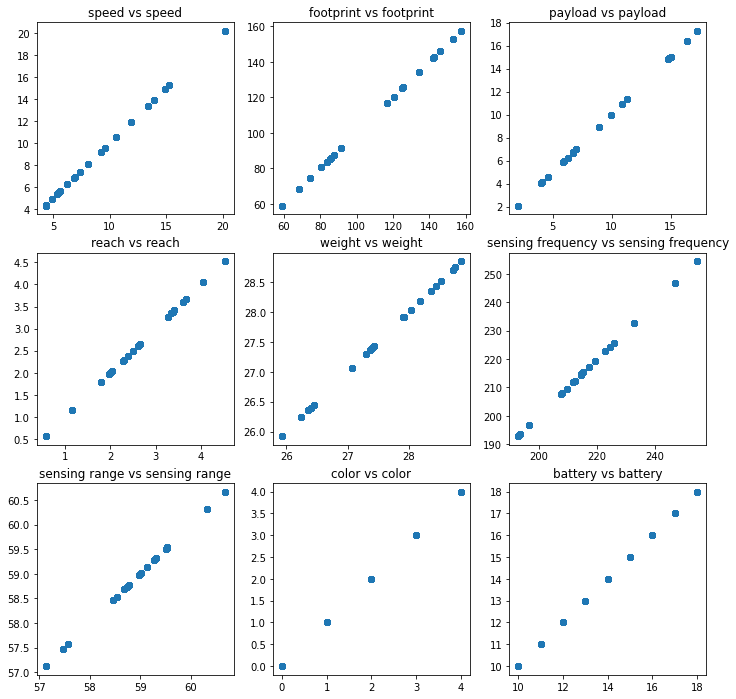

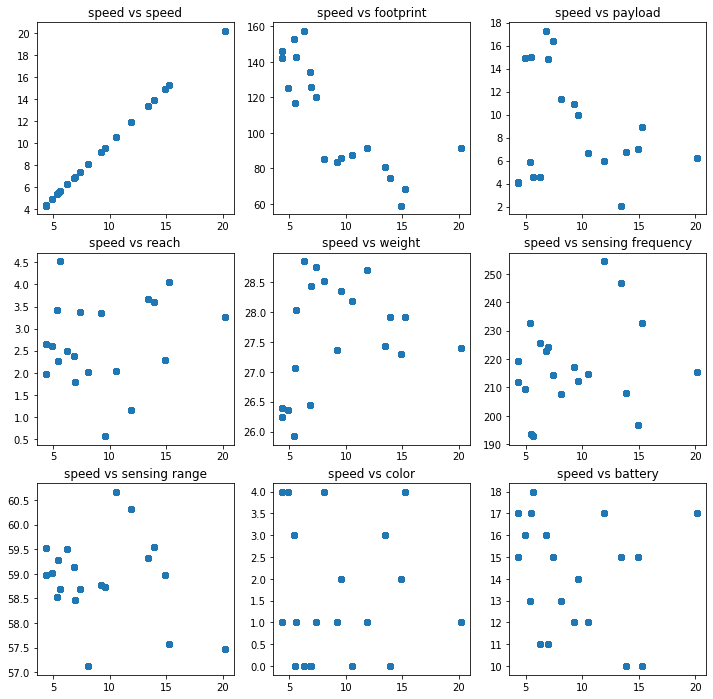

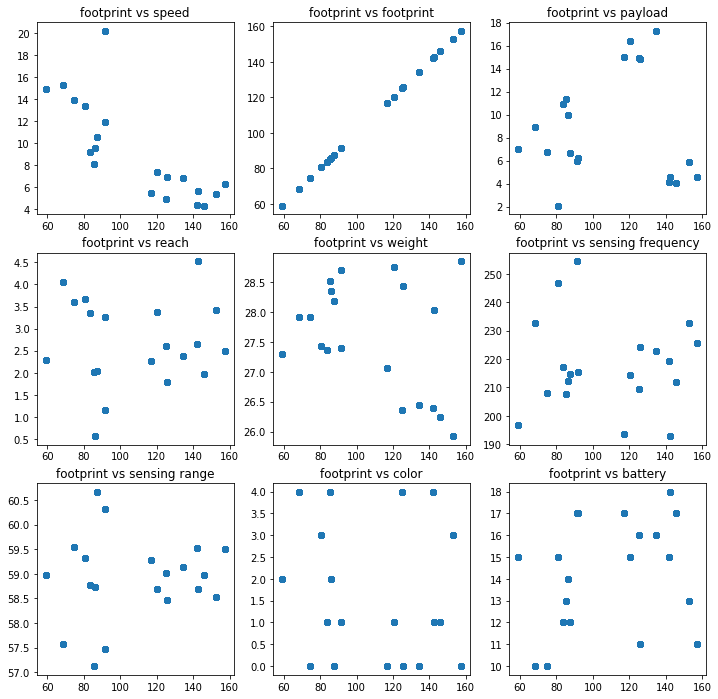

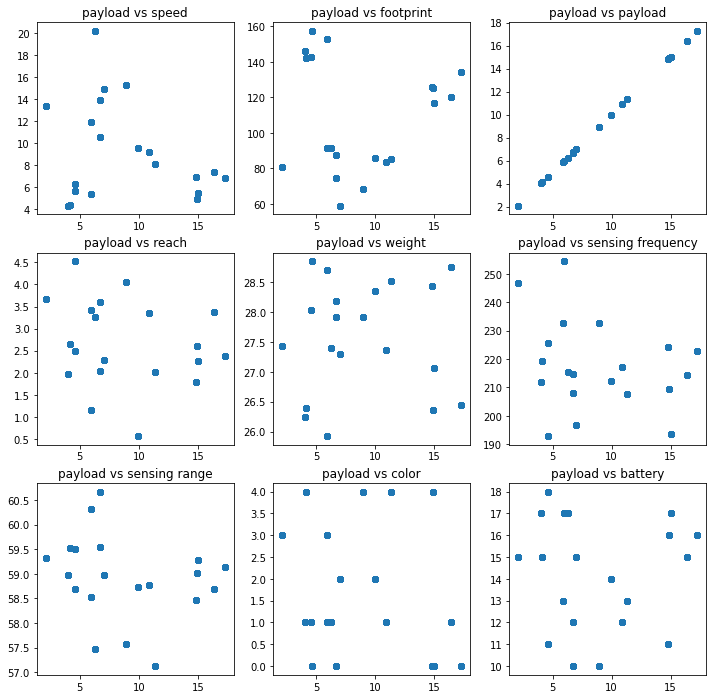

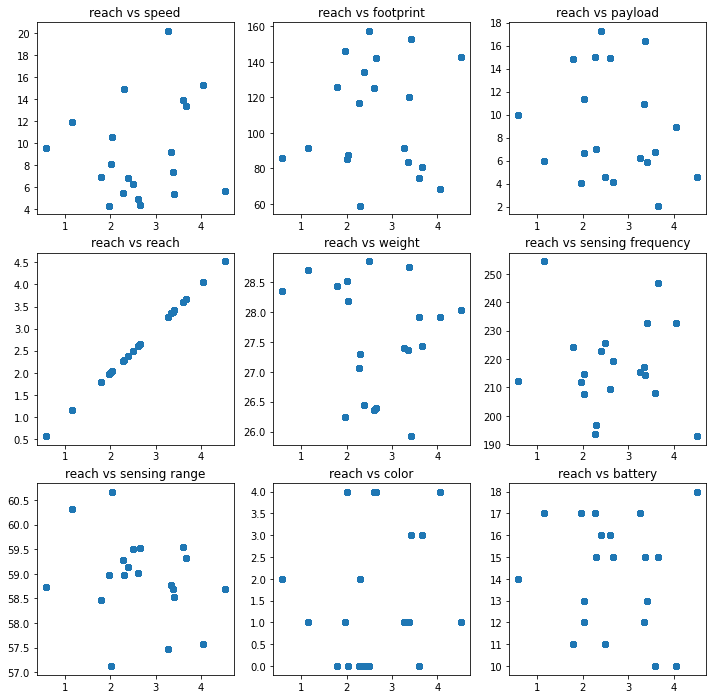

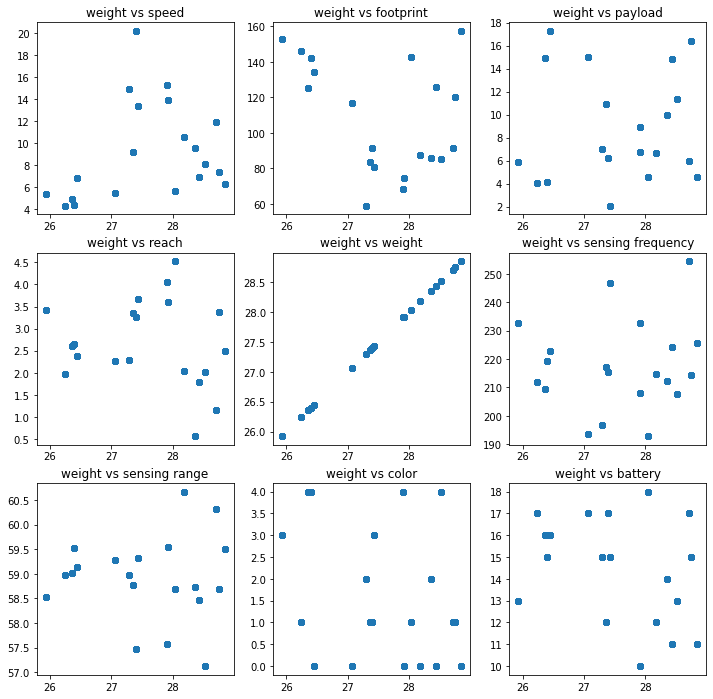

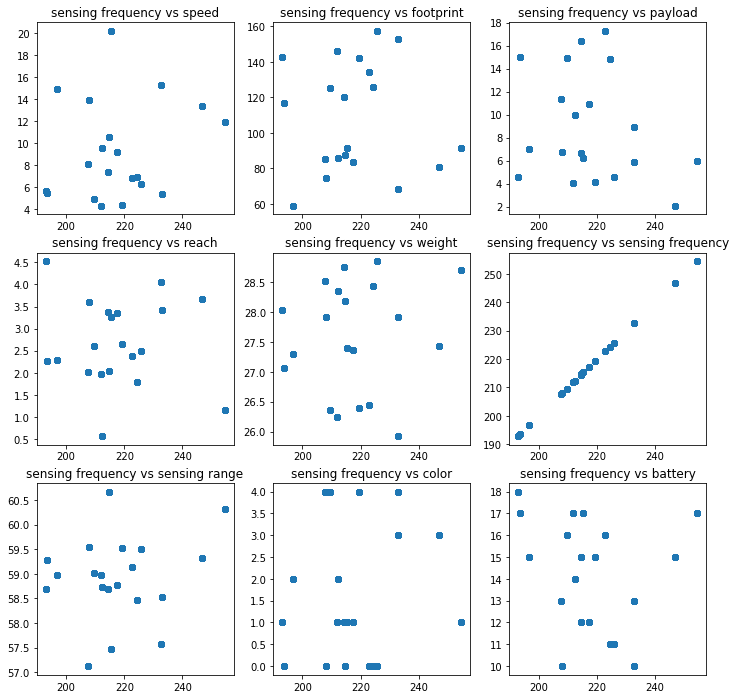

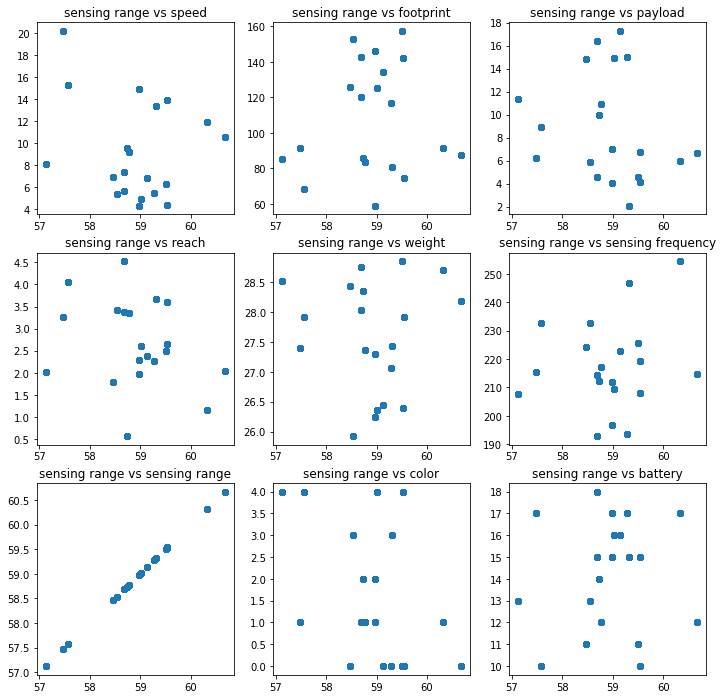

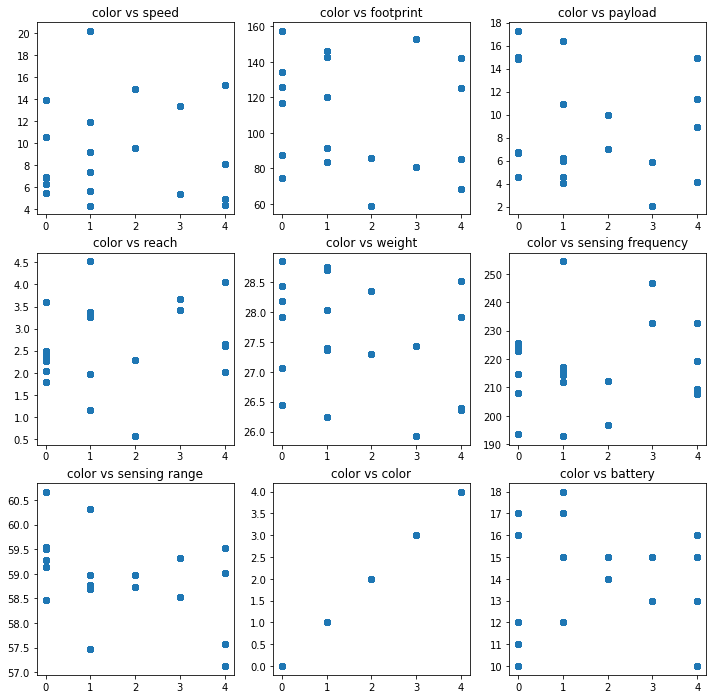

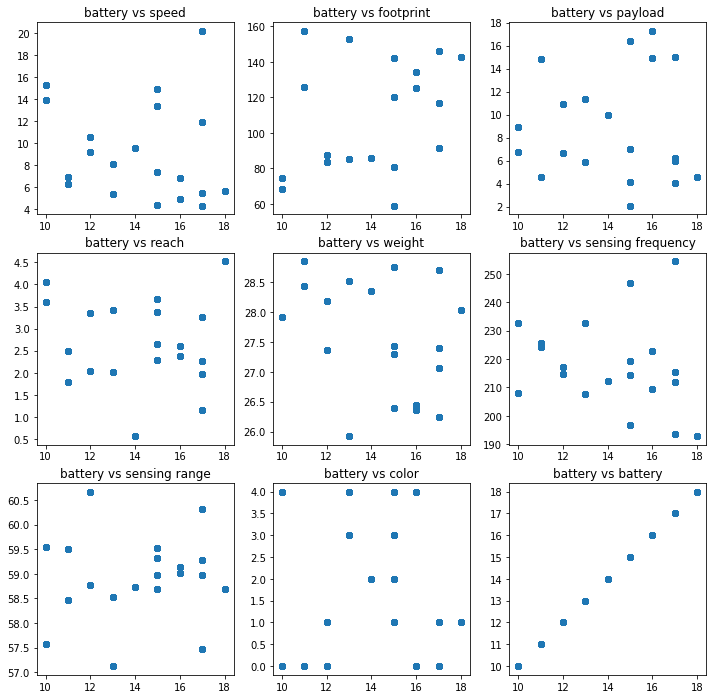

In [9]:
plt.rcParams["figure.figsize"] = (12,12)

#self maps
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.scatter(Q_det[:,:,i], Q_det[:,:,i],alpha=0.2)
    ax.set_title(traits[i] + " vs "+ traits[i] )

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(Q_det[:,:,t], Q_det[:,:,i],alpha=0.5)
        ax.set_title(traits[t] + " vs "+ traits[i] )

## Y optimal formualtion

In [45]:
#speed,footprint,payload,reach,weight,sensing frequency,sensing range,color,battery capacity
y1 = [1,0,1,1,0,1,1,0,0]#pick
y2 = [0,1,0,0,0,1,1,0,1]#search for target
y3 = [1,1,1,1,1,1,0,0,1]#move object
y_star = np.array([y1,y2,y3]).astype(np.float)
y_star

array([[1., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1.]])

In [11]:
#Random
# y_star = np.eye(num_tasks)[np.random.choice(num_tasks, num_traits)].T 
# y_star

In [58]:
#weight init
init_weight = np.eye(num_tasks)[np.random.choice(num_tasks, num_traits)].T 
init_weight

array([[1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 1., 0., 1., 0., 1.]])

In [63]:
def minimize_func(input_x, i, weight):
        x = input_x.reshape((num_tasks,num_species))
        diff = abs(y_star - x@Q[i])
        weighted_diff = diff*weight
        # print(diff*weight)
        return LA.norm(weighted_diff)

In [64]:
x = np.random.randint(0,2,size = (3,4))
in_x = x.flatten()
minimize_func(in_x, 0, init_weight)

[[ 16.2669641    0.           0.           0.           0.
  443.60505395   0.           0.           0.        ]
 [  0.           0.          34.0596507    0.           0.
    0.           0.           6.           0.        ]
 [  0.         281.19319549   0.           6.02775551  81.69111981
    0.         173.78947862   0.          34.        ]]


1373.5196348564211

In [65]:
X = []
for i in range(num_demo):
    res = minimize(minimize_func, in_x, args=(i, init_weight), method='Powell', tol=1e-6)
    # print(res)
    X_app = np.array(res.x).reshape((num_tasks,num_species))
    X_app[X_app<0] = 0
    X.append(X_app)

X = np.array(X)
X.shape

[[ 16.2669641    0.           0.           0.           0.
  443.60505395   0.           0.           0.        ]
 [  0.           0.          34.0596507    0.           0.
    0.           0.           6.           0.        ]
 [  0.         281.19319549   0.           6.02775551  81.69111981
    0.         173.78947862   0.          34.        ]]
[[ 16.2669641    0.           0.           0.           0.
  443.60505395   0.           0.           0.        ]
 [  0.           0.          34.0596507    0.           0.
    0.           0.           6.           0.        ]
 [  0.         281.19319549   0.           6.02775551  81.69111981
    0.         173.78947862   0.          34.        ]]
[[ 27.66996688   0.           0.           0.           0.
  682.53881451   0.           0.           0.        ]
 [  0.           0.          34.0596507    0.           0.
    0.           0.           6.           0.        ]
 [  0.         281.19319549   0.           6.02775551  81.69111981
   

KeyboardInterrupt: 

In [ ]:
Y = []
for i in range(num_demo):
    Y.append(X[i]@Q[i])
Y = np.array(Y)
Y.shape

(1000, 3, 9)

In [ ]:
X = []
for i in range(num_demo):
    def minimize_func(input_x):
        x = input_x.reshape((num_tasks,num_species))
        diff = (y_star - x@Q[i])
        return LA.norm(diff)

    res = minimize(minimize_func, in_x, method='CG', tol=1e-6)
    # print(res)
    X_app = np.array(res.x).reshape((num_tasks,num_species))
    X_app[X_app<0] = 0
    X.append(X_app)

X = np.array(X)
X.shape

Y = []
norms = []

for i in range(num_demo):
    Y_i = X[i]@Q[i]
    Y.append(Y_i)
    norms.append(LA.norm(y_star-Y_i))

Y = np.array(Y)
Y.shape


print(min(norms))
print(np.mean(norms))
print(max(norms))


13.076740818556903
58.75197559484118
224.39786684815846


In [ ]:
X = []
for i in range(num_demo):
    def minimize_func(input_x):
        x = input_x.reshape((num_tasks,num_species))
        diff = (y_star - x@Q[i])
        return LA.norm(diff)

    res = minimize(minimize_func, in_x, method='Nelder-Mead', tol=1e-6)
    # print(res)
    X_app = np.array(res.x).reshape((num_tasks,num_species))
    X_app[X_app<0] = 0
    X.append(X_app)

X = np.array(X)
X.shape

Y = []
norms = []

for i in range(num_demo):
    Y_i = X[i]@Q[i]
    Y.append(Y_i)
    norms.append(LA.norm(y_star-Y_i))

Y = np.array(Y)
Y.shape


print(min(norms))
print(np.mean(norms))
print(max(norms))


8.211702178622172
226.87565039391453
2810.691294160809


In [52]:
X = []
for i in range(num_demo):
    def minimize_func(input_x):
        x = input_x.reshape((num_tasks,num_species))
        diff = (y_star - x@Q[i])
        return LA.norm(diff)

    res = minimize(minimize_func, in_x, method='Powell', tol=1e-6)
    # print(res)
    X_app = np.array(res.x).reshape((num_tasks,num_species))
    X_app[X_app<0] = 0
    X.append(X_app)

X = np.array(X)
X.shape

Y = []
norms = []

for i in range(num_demo):
    Y_i = X[i]@Q[i]
    Y.append(Y_i)
    norms.append(LA.norm(y_star-Y_i))

Y = np.array(Y)
Y.shape


print(min(norms))
print(np.mean(norms))
print(max(norms))


13.076645958233419
68.1580715303444
729.3493097516811


In [ ]:
import numpy as np
from scipy import optimize
## same xdata and ydata as stated in question

def guess_initial_parameters(xs, ys):
    """
    xs          :   type<list> or type<array>
    ys          :   type<list> or type<array>
    """
    ## GUESS SLOPE
    slope = (ys[-1]-ys[0])/(xs[-1]-xs[0])
    alpha = 1/slope
    ## GUESS INTERCEPT
    intercept = np.mean([ys[-1] - xs[-1]/alpha, ys[0] - xs[0]/alpha])
    return [alpha, intercept]

def update_weights(residuals, power=1):
    """
    residuals   :   type<list> or type<array>
    power       :   type<float>
    """
    ## INVERT RESIDUALS
    invs = [1/residuals[idr] for idr in range(len(residuals))]
    ## NORMALIZE RESIDUALS
    invs = [abs(inv)**power for inv in invs]
    total = sum(invs)
    return [invs[idv]/total for idv in range(len(invs))]

def fit_func(ps, xs):
    """
    ps          :   [alpha, intercept]
    xs          :   type<list> or type<array>
    """
    ## FIT TO EQUATION OF LINE
    return [xs[idx]/ps[0] + ps[1] for idx in range(len(xs))] ## alpha = 1/slope

def get_residuals(ps, xs, ys):
    """
    ps          :   [alpha, intercept]
    xs          :   type<list> or type<array>
    ys          :   type<list> or type<array>
    """
    ## GET LINEAR FIT
    ys_trial = fit_func(ps, xs)
    ## GET RESIDUALS
    residuals = [(ys[idx] -  ys_trial[idx])**2 for idx in range(len(ys))]
    return residuals

def err_func(ps, xs, ys, wts):
    """
    ps          :   [alpha, intercept]
    xs          :   type<list> or type<array>
    ys          :   type<list> or type<array>
    wts         :   type<list> or type<array>
    """
    ## GET RESIDUALS
    residuals = get_residuals(ps, xs, ys)
    ## SUM WEIGHTED RESIDUALS
    return sum([wts[idr] * residuals[idr] for idr in range(len(residuals))])

def get_gls_fit(xs, ys, ps_init, weights=None, power=2, routine='Nelder-Mead'):
    """
    xs          :   type<list> or type<array>
    ys          :   type<list> or type<array>
    ps_init     :   [alpha, intercept]
    weights     :   None or type<list> or type<array>
    power       :   type<float>
    routine     :   'Nelder-Mead'
    """
    ## GET INITIAL PARAMETER GUESS
    if type(ps_init) == (list or np.array):
        pass
    elif ps_init == 'estimate':
        ps_init = guess_initial_parameters(xs, ys)
    else:
        raise ValueError("ps_init = type<list> or type<array> or 'estimate'")
    ## GET WEIGHTS
    if weights is None:
        wts = np.ones(len(xs))
        print(">>>>>>>>>>>\nORDINARY LEAST SQUARES (OLS) FIT:")
    else:
        wts = weights[:]
        print(">>>>>>>>>>>\nGENERALIZED LEAST SQUARES (GLS) FIT:")
    ## MINIMIZE SUM OF WEIGHTED RESIDUALS
    ans = optimize.minimize(err_func, x0=ps_init, args=(xs, ys, wts,), method=routine)
    ## GET OPTIMIZED PARAMETERS
    alpha, intercept = ans.x[0], ans.x[1]
    ## GET RESIDUALS
    residuals = np.array(get_residuals([alpha, intercept], xs, ys))
    ## GET UPDATED WEIGHTS FOR REFITTING
    wts_upd = np.array(update_weights(residuals, power))
    ## PRINT & RETURN RESULTS
    print("\n   ALPHA = %.3f, INTERCEPT = %.3f" %(alpha, intercept))
    print("\n   RESIDUALS:  \n", residuals)
    print("\n   WEIGHTS (used): \n", wts)
    print("\n   WEIGHTS (updated):  \n", wts_upd, "\n\n")
    return [alpha, intercept], residuals, wts_upd